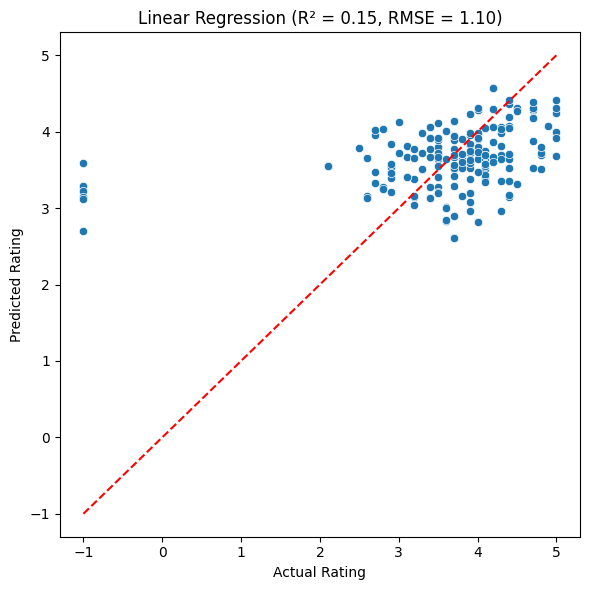

📊 분류 정확도 (Accuracy): 0.78


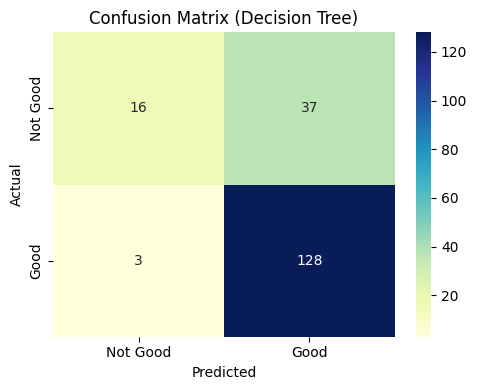

✅ 교차 검증 평균 정확도: 0.74 (표준편차: 0.02)


In [21]:
# 데이터 처리 및 시각화를 위한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델과 평가 지표 관련 라이브러리 불러오기
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델
from sklearn.tree import DecisionTreeClassifier  # 결정 트리 분류 모델
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error  # 평가 지표
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold  # 데이터 분할 및 교차 검증
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # 스케일링과 원-핫 인코딩
from sklearn.compose import ColumnTransformer  # 열별 전처리
from sklearn.pipeline import Pipeline  # 파이프라인 구성

# 1. 전처리된 Glassdoor 데이터 불러오기
df = pd.read_csv("glassdoor_cleaned.csv")

# 2. 사용할 입력 변수 정의(수치형 변수와 범주형 변수 구분)
numeric_features = ['avg_salary', 'Company_age', 'Position_Encoded']  # 연속형 변수
categorical_features = ['Size_cleaned', 'Ownership_Grouped', 'Location_state_binned']  # 범주형 변수

# 3. 전처리 파이프라인 구성

# 숫자형 변수는 StandardScaler를 통해 평균 0, 표준편차 1로 스케일링(수치형 변수는 표준화)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 범주형 변수는 OneHotEncoder를 통해 더미 변수(0/1)로 변환(범주형 변수는 원핫 인코딩)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # 새로운 값 무시
])

# 열별로 적절한 전처리를 적용하기 위한 ColumnTransformer 정의(수치형/범주형에 서로 다른 전처리 적용)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4. 입력 변수(X), 타깃 변수(y) 정의(X는 전처리 대상 피처 ,y_reg: 회귀용 타깃,y_cls: 분류용 타깃 (3.5 이상이면 1))
X = df[numeric_features + categorical_features]  # 입력 데이터프레임
y_reg = df['Rating']  # 회귀용 타깃: 평점
y_cls = (df['Rating'] >= 3.5).astype(int)  # 분류용 타깃: 3.5 이상이면 1, 아니면 0

# ColumnTransformer를 통해 전처리 적용
X_processed = preprocessor.fit_transform(X)

# ---------------------- [1] 회귀 분석 (Linear Regression) ----------------------

# 학습/테스트 데이터 분할 (80% 학습, 20% 테스트)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_processed, y_reg, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
reg = LinearRegression()
reg.fit(X_train_r, y_train_r)

# 테스트 데이터에 대한 예측 수행
y_pred_r = reg.predict(X_test_r)

# 평가 지표 계산: R²: 모델 설명력, RMSE: 예측 오차
r2 = r2_score(y_test_r, y_pred_r)  # 설명력 (1에 가까울수록 좋음)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))  # 예측 오차 (낮을수록 좋음)

# 예측 결과 시각화 (산점도와 기준선) /실제 vs 예측 산점도 그래프 출력
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_r, y=y_pred_r)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')  # 완벽 예측선
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title(f"Linear Regression (R² = {r2:.2f}, RMSE = {rmse:.2f})")
plt.tight_layout()
plt.show()

# ---------------------- [2] 분류 분석 (Decision Tree Classifier) ----------------------

# 학습/테스트 데이터 분할
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_processed, y_cls, test_size=0.2, random_state=42)

# 결정 트리 모델 생성 (최대 깊이 제한)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_c, y_train_c)

# 예측 수행
y_pred_c = clf.predict(X_test_c)

# 정확도 및 혼동행렬 계산
acc = accuracy_score(y_test_c, y_pred_c)
cm = confusion_matrix(y_test_c, y_pred_c)

# 결과 출력
print(f"📊 분류 정확도 (Accuracy): {acc:.2f}")

# 혼동 행렬 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Not Good", "Good"], yticklabels=["Not Good", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Tree)")
plt.tight_layout()
plt.show()

# ---------------------- [3] 교차 검증 (Stratified K-Fold) ----------------------
#StratifiedKFold를 이용해 클래스 불균형을 고려한 5-Fold 교차 검증 수행, 평균 정확도와 분산 출력
# StratifiedKFold: 클래스 비율 유지하며 5개로 나눔
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행 (정확도 기준)
cv_scores = cross_val_score(clf, X_processed, y_cls, cv=cv, scoring='accuracy')

# 평균 및 표준편차 출력
print(f"✅ 교차 검증 평균 정확도: {cv_scores.mean():.2f} (표준편차: {cv_scores.std():.2f})")



